Improvised model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load the dataset
df = pd.read_csv('ecg_combined_frequency_data.csv')

# One-Hot Encoding categorical variables (Lead, Wave_Type)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_lead_wave = encoder.fit_transform(df[['Lead', 'Wave_Type']])
encoded_df = pd.DataFrame(encoded_lead_wave, columns=encoder.get_feature_names_out(['Lead', 'Wave_Type','dis']))
df_encoded = pd.concat([df, encoded_df], axis=1).drop(['Lead', 'Wave_Type'], axis=1)

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded[['Start', 'Peak', 'End', 'Amplitude', 'Frequency', 'Magnitude']])
df_encoded[['Start', 'Peak', 'End', 'Amplitude', 'Frequency', 'Magnitude']] = scaled_features

# Handle missing values using KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_encoded_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Feature Engineering: Detect R-peaks
threshold = 0.8
min_distance = 30
r_peaks, _ = find_peaks(df_encoded_imputed["dis"], height=threshold, distance=min_distance)

# Calculate RR Intervals and HRV
rr_intervals = np.diff(r_peaks)
hr = 60 / rr_intervals
hrv = np.std(rr_intervals)

# Pad the arrays to match lengths
max_len = max(len(r_peaks), len(rr_intervals), len(hr))
r_peaks_padded = np.pad(r_peaks, (0, max_len - len(r_peaks)), 'constant', constant_values=0)
rr_intervals_padded = np.pad(rr_intervals, (0, max_len - len(rr_intervals)), 'constant', constant_values=0)
hr_padded = np.pad(hr, (0, max_len - len(hr)), 'constant', constant_values=0)
hrv_padded = np.full(max_len, hrv)

# Create feature matrix
X = pd.DataFrame(np.array([r_peaks_padded, rr_intervals_padded, hr_padded, hrv_padded])).T

# Assuming `y` is the target variable for classification (0 or 1)
y = df_encoded_imputed['dis']  # Replace 'Target' with actual column name


In [16]:
X

,0,1,2,3
0,137.0,94.0,0.638298,23.345176
1,231.0,54.0,1.111111,23.345176
2,285.0,100.0,0.600000,23.345176
3,385.0,60.0,1.000000,23.345176
4,445.0,100.0,0.600000,23.345176
5,545.0,40.0,1.500000,23.345176
6,585.0,100.0,0.600000,23.345176
7,685.0,40.0,1.500000,23.345176
8,725.0,100.0,0.600000,23.345176
9,825.0,40.0,1.500000,23.345176


In [17]:
threshold_amplitude = 0  # Set your threshold for binary classification
y = (df_encoded_imputed['Amplitude'][:X.shape[0]] > threshold_amplitude).astype(int)
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=52, stratify=y)

# Reshape X for CNN: (samples, time_steps, features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)


In [19]:
# CNN Model
model = Sequential()

# Convolutional Layer 1
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Convolutional Layer 2
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Flatten & Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 4, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 4, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,561 (197.50 KB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [20]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.001
    return lr

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)]
)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2632 - loss: 1.0733 - val_accuracy: 0.0000e+00 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6842 - loss: 0.6043 - val_accuracy: 1.0000 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8421 - loss: 0.4664 - val_accuracy: 1.0000 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.2774 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9474 - loss: 0.2502 - val_accuracy: 1.0000 - val_loss: 7.6212e-04 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.1598 - val_accuracy: 1.0000 - val_loss: 3.2889e-04 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.1512 - val_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


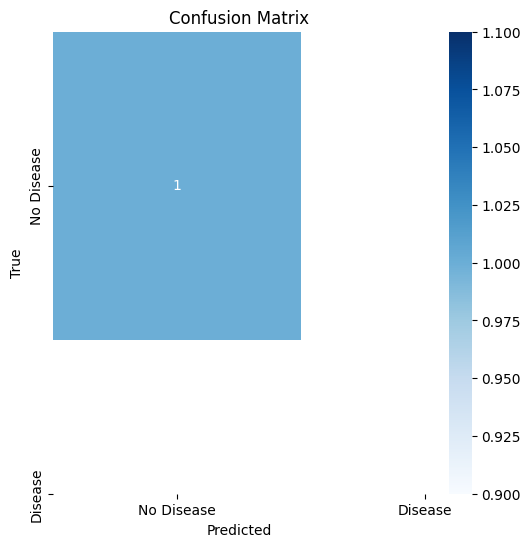

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



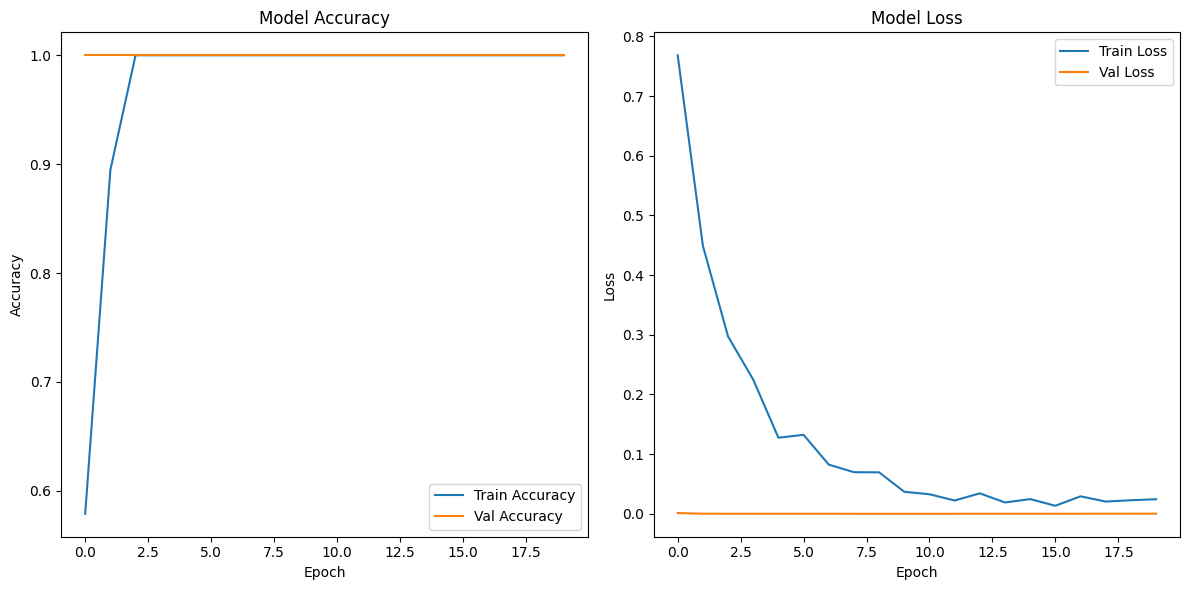

In [14]:
# Predict on validation set
y_pred = (model.predict(X_val_reshaped) > 0.5).astype("int32")

# Compute Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Training Progress Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
